In [1]:
import numpy as np
#import warnings
#warnings.filterwarnings("ignore")

### Case description:

$\displaystyle u = 0, v = 0.5 \alpha, \rho = 0, S_0 = 100, \alpha_0 = 1$ <br>

The	initial	implied	volatility surface is flat at $20\%$ for all strikes and maturities $\Rightarrow v_{\text{loc}}(S, t) \equiv 20\%$

<br>

$\displaystyle u = 0, \rho = 0 \Rightarrow$ the discretized PDE could be simplifed as: $$\frac{p_{i, j}^{k + 1} - p_{i, j}^{k}}{\Delta t}  - \frac{1}{2}\frac{l^2(S_{i+1}, t_k) \alpha_j^2 S_{i+1}^2 p_{i+1, j}^k + l^2(S_{i-1}, t_k) \alpha_j^2 S_{i-1}^2 p_{i-1, j}^k - 2l^2(S_{i}, t_k) \alpha_j^2 S_{i}^2 p_{i, j}^k}{\Delta S^2} - \frac{1}{2}\frac{v^2p_{i, j+1}^k + v^2p_{i, j-1}^k - 2v^2p_{i, j}^k}{\Delta \alpha^2} = 0$$

$\displaystyle \Rightarrow$ $$p_{i, j}^{k + 1} = p_{i, j}^{k} + \Delta t \Big[ \frac{1}{2}\frac{l^2(S_{i+1}, t_k) \alpha_j^2 S_{i+1}^2 p_{i+1, j}^k + l^2(S_{i-1}, t_k) \alpha_j^2 S_{i-1}^2 p_{i-1, j}^k - 2l^2(S_{i}, t_k) \alpha_j^2 S_{i}^2 p_{i, j}^k}{\Delta S^2} + \frac{1}{2}\frac{v^2p_{i, j+1}^k + v^2p_{i, j-1}^k - 2v^2p_{i, j}^k}{\Delta \alpha^2} \Big]$$

<br>

We choose $\displaystyle S_l = 50, \, S_u = 150, \, N_s = 100, \, \alpha_l = 0, \, \alpha_u = 2, \, N_{\alpha} = 20, \, t_l = 0, \, t_u = 1, \, N_t = 200$ to solve $\displaystyle l(S, t)$:

In [2]:
# Define parameters
vLoc = 0.2 ** 2
S0, alpha0 = 100., 1.
Sl, Su, Ns = 50., 150., 100
alphaL, alphaU, Nalpha = 0., 2., 50
tl, tu, Nt = 0., 1., 200
# v is a function of alpha
def vAlpha(alpha):
    return 0.5*alpha

# compute discretized step
dS = (Su - Sl)/Ns
dAlpha = (alphaU - alphaL)/Nalpha
dt = (tu - tl)/Nt

# initialize the matrix to store l(S,t) for all Si and tk
leverage = np.zeros((Ns + 1, Nt + 1))
# initiliaze the matrix to store p(t, S, alpha) forall Si, alpha_j at time k and k + 1
density_k = np.zeros((Ns + 1, Nalpha + 1))
density_kp = np.zeros((Ns + 1, Nalpha + 1))

# step 2, compute l(S, 0)
# define the density at time 0:
density_k[int((S0 - Sl)/dS), int((alpha0 - alphaL)/dAlpha)] = 1
for i in range(Ns + 1):
    # compute the expectation of alpha^2 when S = Si, t = 0
    sum1, sum2 = 0, 0
    for j in range(Nalpha + 1):
        sum1 += density_k[i, j] * dAlpha
        sum2 += (j * dAlpha) ** 2 * density_k[i, j] * dAlpha
    if (sum2 == 0):
        reci_E = 0
    else:
        reci_E = sum1 / sum2
    
    # compute l(Si, 0)
    leverage[i, 0] = (vLoc * reci_E) ** 0.5

# repeat step 2 and step 3
# firstly compute density at time tk, then compute l(S, tk)
for k in range(1, Nt):
    # compute the density by discretized PDE
    density_kp = np.zeros((Ns + 1, Nalpha + 1))
    for i in range(Ns + 1):
        if (i == 0):
            for j in range(Nalpha + 1):
                if (j == 0):
                    term1 = 0.5*(vAlpha((j + 1)*dAlpha)**2 * density_k[i, j + 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i+1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i + 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
                elif (j < Nalpha):
                    term1 = 0.5*(vAlpha((j - 1)*dAlpha)**2 * density_k[i, j - 1] + 
                                 vAlpha((j + 1)*dAlpha)**2 * density_k[i, j + 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i+1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i + 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
                else:
                    term1 = 0.5*(vAlpha((j - 1)*dAlpha)**2 * density_k[i, j - 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i+1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i + 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
        elif (i < Ns):
            for j in range(Nalpha + 1):
                if (j == 0):
                    term1 = 0.5*(vAlpha((j + 1)*dAlpha)**2 * density_k[i, j + 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i+1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i + 1, j] +
                                                 leverage[i-1, k - 1]**2 * (Sl+(i-1)*dS)**2 * density_k[i - 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
                elif (j < Nalpha):
                    term1 = 0.5*(vAlpha((j - 1)*dAlpha)**2 * density_k[i, j - 1] + 
                                 vAlpha((j + 1)*dAlpha)**2 * density_k[i, j + 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i+1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i + 1, j] +
                                                 leverage[i-1, k - 1]**2 * (Sl+(i-1)*dS)**2 * density_k[i - 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
                else:
                    term1 = 0.5*(vAlpha((j - 1)*dAlpha)**2 * density_k[i, j - 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i+1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i + 1, j] +
                                                 leverage[i-1, k - 1]**2 * (Sl+(i-1)*dS)**2 * density_k[i - 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
        else:
            for j in range(Nalpha + 1):
                if (j == 0):
                    term1 = 0.5*(vAlpha((j + 1)*dAlpha)**2 * density_k[i, j + 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i - 1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i - 1, j] - 
                                                 2*leverage[i, k - 1 - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
                elif (j < Nalpha):
                    term1 = 0.5*(vAlpha((j - 1)*dAlpha)**2 * density_k[i, j - 1] + 
                                 vAlpha((j + 1)*dAlpha)**2 * density_k[i, j + 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i-1, k - 1]**2 * (Sl+(i-1)*dS)**2 * density_k[i - 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)
                else:
                    term1 = 0.5*(vAlpha((j - 1)*dAlpha)**2 * density_k[i, j - 1] - 
                                 2 * vAlpha(j*dAlpha)**2 * density_k[i, j]) / (dAlpha) ** 2
                    term2 = 0.5*(j*dAlpha)**2 * (leverage[i - 1, k - 1]**2 * (Sl+(i+1)*dS)**2 * density_k[i - 1, j] - 
                                                 2*leverage[i, k - 1]**2 * (Sl+i*dS)**2 * density_k[i, j]) / (dS)**2
                    density_kp[i, j] = max(density_k[i, j] + dt*(term1 + term2), 0)

    # update the density
    density_k = density_kp.copy()
        
    # compute l(S, tk)
    for i in range(Ns + 1):
        # compute the expectation of alpha^2 when S = Si, t = tk
        sum1, sum2 = 0, 0
        for j in range(Nalpha + 1):
            sum1 += density_k[i, j] * dAlpha
            sum2 += (j * dAlpha) ** 2 * density_k[i, j] * dAlpha
        if (sum2 == 0):
            reci_E = 0
        else:
            reci_E = sum1 / sum2
    
        # compute l(Si, tk)
        leverage[i, k] = (vLoc * reci_E) ** 0.5

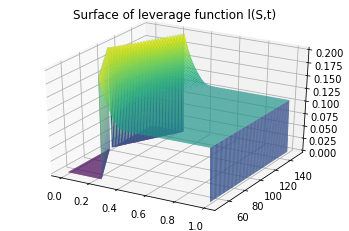

In [3]:
# plot the result

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


Slin = np.linspace(Sl, Su, num = Ns + 1, endpoint = True)
tlin = np.linspace(tl, tu, num = Nt + 1, endpoint = True)
Tgrid, Sgrid = np.meshgrid(tlin, Slin)
ax = plt.axes(projection='3d')
ax.plot_surface(Tgrid, Sgrid, leverage, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Surface of leverage function l(S,t)');